In [8]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [9]:
bus = pd.read_csv('~/Downloads/arrival_times.csv')
bus = bus.dropna(axis=0, how='any')

# combine date and time into a single timestamp
bus['scheduled'] = pd.to_datetime(bus['OPD_DATE'] + ' ' + bus['SCH_STOP_TM'])
bus['actual'] = pd.to_datetime(bus['OPD_DATE'] + ' ' + bus['ACT_STOP_TM'])

# if scheduled & actual span midnight, then the actual day needs to be adjusted
minute = np.timedelta64(1, 'm')
hour = 60 * minute
diff_hrs = (bus['actual'] - bus['scheduled']) / hour
bus.loc[diff_hrs > 20, 'actual'] -= 24 * hour
bus.loc[diff_hrs < -20, 'actual'] += 24 * hour
bus['minutes_late'] = (bus['actual'] - bus['scheduled']) / minute

bus['route'] = bus['RTE'].replace({673: 'C', 674: 'D', 675: 'E'})
bus['direction'] = bus['DIR'].replace({'N': 'northbound', 'S': 'southbound'})

bus = bus[['route', 'direction', 'scheduled', 'actual', 'minutes_late']].copy()

In [10]:
bus_c_n = bus[(bus['route'] == 'C') &
                 (bus['direction'] == 'northbound')].copy()

bus_c_n = bus_c_n.sort_values('scheduled')

minute = np.timedelta64(1, 'm')
bus_c_n['sched_inter'] = bus_c_n['scheduled'].diff() / minute

# Modeling Wait Times

We are interested in modeling the experience of someone waiting at a bus stop. We could develop a complex model that involves the intervals between scheduled arrivals, the bus line, and direction. Instead, we take a simpler approach and narrow the focus to one line, one direction, and one scheduled interval. We examine the northbound C line stops that are scheduled to arrive 12 minutes apart. Both the complex and the narrow approaches are legitimate, but we do not yet have the tools to approach the complex model (see {numref}`Chapter %s <ch:linear>` for more details on modeling). 

In [11]:
bus_c_n_12 = bus_c_n[bus_c_n['sched_inter'] == 12].copy()

So far, we have examined the distribution of the number of minutes the bus is late. We create another histogram of this delay for the subset of data that we are analyzing (northbound C line stops that are scheduled to arrive 12 minutes after the previous bus).

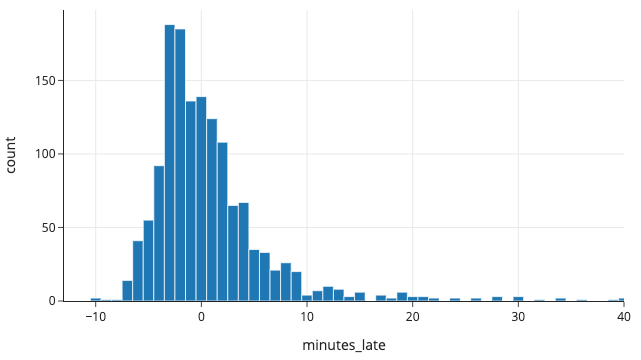

In [12]:
fig = px.histogram(bus_c_n_12, x='minutes_late', 
                   nbins=120, width=450, height=300)

fig.update_xaxes(range=[-13, 40])

fig.show()

And, we calculate the minimum, maximum, and median lateness.

In [13]:
print(f" smallest amount late:  {np.min(bus_c_n_12['minutes_late']):.2f} minutes\n",
      f"greatest amount late:  {np.max(bus_c_n_12['minutes_late']):.2f} minutes\n",
      f"median amount late: {np.median(bus_c_n_12['minutes_late']):.2f} minutes\n")

 smallest amount late:  -10.20 minutes
 greatest amount late:  57.00 minutes
 median amount late: -0.50 minutes



Interestingly, the northbound, 12-minute-apart, buses on the C line are more often early than not!

Now, let's revisit our question to confirm that we are on track for answering it. A summary of how late the buses are does not quite address the experience of the person waiting for the bus. When someone arrives at a bus stop, they need to wait for the next bus to arrive. {numref}`Figure %s <BusDiagram>` shows an idealization of time passing as passengers and buses arrive at the bus stop. If people are arriving at random times at the bus stop, notice that they are more likely to arrive in a time interval where the bus is delayed because there's a longer interval between buses. This arrival pattern is an example of size-biased sampling. So, to answer the question of what do people experience when waiting for a bus, we need to do more than summarize how late the bus is. 

```{figure} BusDiagram.jpg
---
name: BusDiagram
---

This diagram shows an idealization of a timeline with buses arriving (rectangles above the timeline) and passengers arriving (circles). The time the rider waits for the next bus to arrive is indicated by a curly bracket.
```

We can design a simulation that mimics waiting for a bus over the course of one day, like in {numref}`Chapter %s <ch:theory_datadesign>`.  To do this, we set up a string of scheduled bus arrivals that are 12 minutes apart from 6 am to midnight.

In [14]:
scheduled = 12 * np.arange(91)
scheduled

array([   0,   12,   24, ..., 1056, 1068, 1080])

Then, for each scheduled arrival, we simulate its actual arrival time by adding on a random amount of minutes each bus is late. To do this, we choose the minutes late from the distribution of observed lateness of the actual buses. Notice how we have incorporated the real data in our simulation study by using the distribution of actual delays of the 12-minute apart buses.

In [15]:
minutes_late = bus_c_n_12['minutes_late'].to_numpy()
actual = scheduled + np.random.choice(minutes_late, 
                                     size = 91, replace=True)

We need to sort these arrival times because when a bus is super late, another may well come along before it.


In [16]:
actual.sort()
actual

array([   0.32,   12.48,   17.93, ..., 1055.42, 1064.92, 1081.  ])

We also need to simulate the arrival of people at the bus stop at random times throughout the day. We can use another, different, urn model for the passenger arrivals.  For the passengers, we put a marble in the urn with a time on it.  These times run from time 0, which stands for 6 am, to the arrival of the last bus at midnight, which is 1068 minutes past 6 am, and to match the way the bus times are measured in our data, we make the times 1/100 of a minute apart.  

In [17]:
pass_arrival_times = np.arange(100*1068)
pass_arrival_times / 100

array([   0.  ,    0.01,    0.02, ..., 1067.97, 1067.98, 1067.99])

Now, we can simulate the arrival of, say, 500 people, at the bus stop throughout the day.  We draw 500 times from this urn, replacing the marbles between draws.

In [18]:
sim_arrival_times = np.random.choice(pass_arrival_times, 
                                     size = 500, replace=True)/100
sim_arrival_times.sort()
sim_arrival_times

array([   1.61,    4.62,    5.32, ..., 1060.74, 1061.83, 1067.38])

To find out how long each individual waits, we look for the soonest bus to arrive after their sampled time. The difference between these two times (the sampled time of the person and the soonest bus arrival after that) is how long the person waits. 

In [19]:
i = np.searchsorted(actual, sim_arrival_times, side='right')
sim_wait_times = actual[i] - sim_arrival_times
sim_wait_times

array([10.87,  7.86,  7.16, ...,  4.18,  3.09, 13.62])

We can set up a complete simulation where we simulate, say, 200 days of bus arrivals and for each day, we simulate 500 people arriving at the bus stop at random times throughout the day. In total, that's 100,000 simulated wait times.   

In [20]:
sim_wait_times = [ ]

for day in np.arange(0, 200, 1):
    bus_late = np.random.choice(minutes_late, size = 91, replace=True)
    actual = scheduled + bus_late
    actual.sort()
    sim_arrival_times = np.random.choice(pass_arrival_times, 
                                     size = 500, replace=True)/100
    sim_arrival_times.sort()
    i = np.searchsorted(actual, sim_arrival_times, side='right')
    sim_wait_times = np.append(sim_wait_times, actual[i] - sim_arrival_times)
    

We make a histogram of these simulated waiting times to examine the distribution.

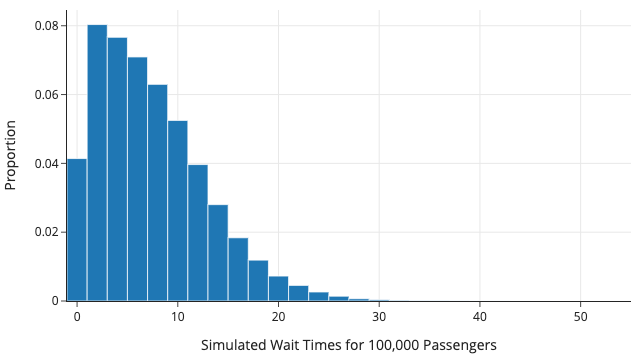

In [21]:
fig = px.histogram(x=sim_wait_times, nbins=40,
                   histnorm='probability density',
                   width=450, height=300)


fig.update_xaxes(title="Simulated Wait Times for 100,000 Passengers")
fig.update_yaxes(title="Proportion")
fig.show()

As we expect, we find a skewed distribution.  We can model this by a constant where we use absolute loss to select the best constant. We saw in {numref}`Chapter %s <ch:modeling>` that absolute loss gives us the median wait time.

In [22]:
print(f"median wait time: {np.median(sim_wait_times):.2f} minutes")

median wait time: 6.44 minutes


The median of about six and a half minutes doesn't seem too long.
While our model captures the typical wait time, we also  want to provide an estimate of the variability in the process. This topic is covered in {numref}`Chapter %s <ch:inf_pred_theory>`.  We can compute the upper quartile of wait times to give us a sense of variability.

In [23]:
print(f"upper quartile wait time: {np.quantile(sim_wait_times, 0.75):.2f} minutes")

upper quartile wait time: 10.59 minutes


The upper quartile is quite large. It's undoubtedly memorable when you have to wait more than 10 minutes for a bus that is supposed to arrive every 12 minutes, and this happens one in four times you take the bus! 